# D-PMP for nonlinear time series prediction

In this example, we'll apply D-PMP to the MAP smoothing problem. We'll tackle the MAP smoothing problem for a classic nonlinear time series model:

$$
\begin{align}
x_t &= \frac{x_{t-1}}{2}+ 25 \frac{x_{t-1}}{1 + x_{t-1}^2} + 8 \cos (1.2t) + u_t \\
y_t &= \frac{x_t^2}{20} + v_t
\end{align}
$$

where $u_t \sim \mathcal{N}(0, \sigma_u^2)$, $v_t \sim \mathcal{N}(0, \sigma_v^2)$, and $x_0 \sim \mathcal{N}(0, \sigma_u^2)$. Generally, $\sigma_u^2 = 10$ and $\sigma_v^2 = 1$ are chosen. Now given an observed sequence $y_{1:T}$, we wish to infer the latent $x_{1:T}$. Effectively applying particle filtering to this model is difficult. In fact, this model was specifically designed to test the abilities of sequential Monte Carlo techniques. Instead of using particle filtering, we'll apply D-PMP to estimate the MAP latent sequence $x_{1:T}$.

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import random
from IPython import display

from pyDPMP.messagepassing import MaxSumMP, fwd_bwd_sched
from pyDPMP.mrf import MRF, calc_potentials
from pyDPMP.particleselection import SelectDiverse
from pyDPMP.util import set_seed
from pyDPMP import DPMP_infer

First, we'll need a function for the log pdf of a normal. Easy-peasy.

In [9]:
def norm_logpdf(x, mu, sigma):
    return -0.5 * ((x - mu) ** 2) / (sigma ** 2)

Next, we'll sample the model:

In [10]:
set_seed(1)

sig_u = np.sqrt(10)
sig_v = np.sqrt(1)

T = 50

def trans_x(x_prev, t):
    return x_prev / 2 \
                + 25 * x_prev / (1 + x_prev ** 2) \
                + 8 * np.cos(1.2 * t)

def obs_y(x_t):
    return (x_t ** 2) / 20.0

x_true = np.zeros(T)
y = np.zeros(T)

x_true[0] = sig_u * np.random.randn()
y[0] = obs_y(x_true[0]) + sig_v * np.random.randn()
for t in range(1, T):
    x_true[t] = trans_x(x_true[t-1], t) + sig_u * np.random.randn()
    y[t] = obs_y(x_true[t]) + sig_v * np.random.randn()

... and plot it:

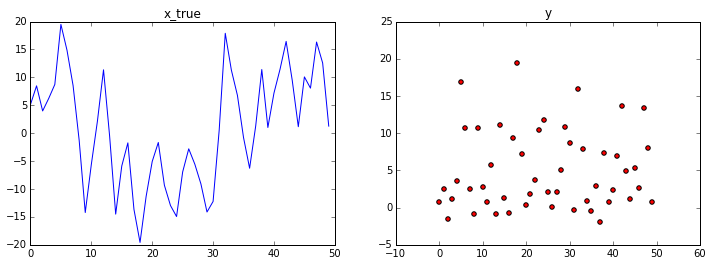

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_true)
plt.title('x_true')

plt.subplot(1, 2, 2)
plt.scatter(range(T), y, c='r')
plt.title('y')

Now, our MRF is pretty straightforward:

In [12]:
nodes = range(T)
edges = [(t, t + 1) for t in range(T - 1)]

node_pot = lambda s, x_s: norm_logpdf(y[s], obs_y(x_s), sig_v)
edge_pot = lambda s, t, x_s, x_t: norm_logpdf(x_t, trans_x(x_s, t), sig_u)

mrf = MRF(nodes, edges, node_pot, edge_pot)

Since our model is simply a Markov chain, we can use a forward/backward message update schedule.

In [13]:
maxsum = MaxSumMP(mrf, sched=fwd_bwd_sched(mrf))

In order to assess what we're up against, we can calculate the max-marginals over a dense discretization since the model is low-dimensional.

In [14]:
# Construct a dense discretization
x_dense = {t: np.linspace(-20, 20, 100) for t in range(T)}

# Calculate all of the potentials on the denes discretization
node_pot_dense, edge_pot_dense = calc_potentials(mrf, x_dense)

# Run Max-Sum
msgs_dense, _ = maxsum.messages(node_pot_dense, edge_pot_dense)

# Calculate the max-marginals at each node
mm_dense = maxsum.log_beliefs(node_pot_dense, edge_pot_dense, msgs_dense)

# Construct max-marginal "image"
mm_img = -1.0 * np.exp(np.array([mm_dense[t] - np.max(mm_dense[t]) for t in range(T)])).T

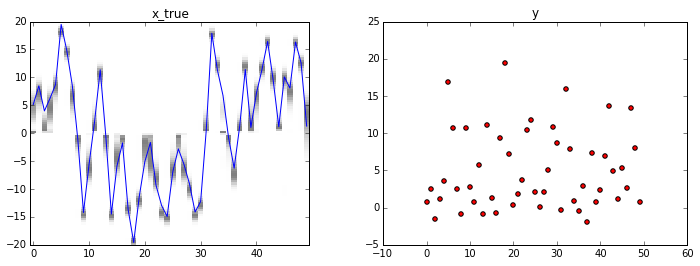

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(mm_img, cmap=cm.gray, extent=[-0.5, T - 0.5, -20, 20], origin='lower', alpha=0.5, interpolation='none')
plt.plot(x_true)
plt.xlim(-0.5, T - 0.5)
plt.title('x_true')

plt.subplot(1, 2, 2)
plt.scatter(range(T), y, c='r')
plt.title('y')

In this case, we'll propose particles based on the transition dynamics applied to random particles from the previous time point.

In [16]:
def proposal(mrf, nAdd, x):
    x_prop = {}
    
    # t = 0
    x_prop[0] = [sig_u * np.random.randn() for _ in range(nAdd[0])]
    
    for t in range(1, T):
        # Pick random particles from x[t - 1] and propogate them according to
        # the transition dynamics.
        x_prop[t] = [trans_x(random.choice(x[t - 1]), t) + sig_u * np.random.randn()
                     for _ in range(nAdd[t])]

    return x_prop

We'll start off with a particle at 0 for each time point. It's not the fanciest initialization ever but oh well.

In [17]:
x0 = {t: [0.0] for t in range(T)}

We want to keep 5 particles around after every run of particle selection.

In [18]:
nParticles = 5

Finally, we'll run D-PMP:

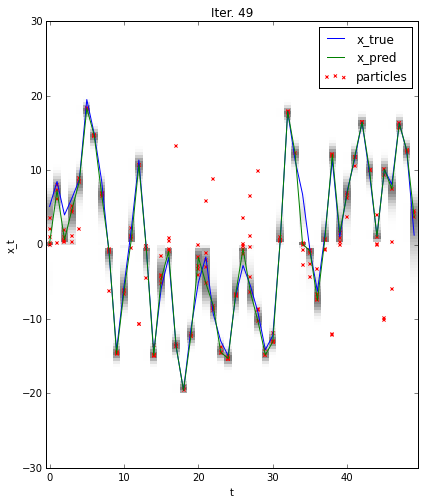

In [19]:
set_seed(1)

plt.figure(figsize=(8, 8))
def callback(info):
    x = info['x']
    xMAP = info['xMAP']
    
    plt.clf()
    plt.imshow(mm_img, cmap=cm.gray, extent=[-0.5, T - 0.5, -20, 20], origin='lower', alpha=0.5, interpolation='none')
    plt.plot(x_true)
    plt.plot(range(T), [xMAP[t] for t in range(T)])
    particles = [(t, x_t) for t in range(T) for x_t in x[t]]
    plt.scatter(*zip(*particles), s=10, c='r', marker='x')
    
    plt.xlim(-0.5, T - 0.5)
    plt.legend(['x_true', 'x_pred', 'particles'])
    plt.xlabel('t')
    plt.ylabel('x_t')
    plt.title('Iter. %d' % info['iter'])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)

xMAP, xParticles, stats = DPMP_infer(mrf,
                                     x0,
                                     nParticles,
                                     proposal,
                                     SelectDiverse(),
                                     maxsum,
                                     conv_tol=None,
                                     max_iters=50,
                                     callback=callback)

display.clear_output(wait=True)